# Data Analysis of Movies by Rating Relative to Age

In [2]:
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MultiLabelBinarizer 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
import category_encoders as ce 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import seaborn as sns
import datetime as dt
import numpy as np
import pandas as pd
import re

In [6]:
 InteractiveShell.ast_node_interactivity = "all" #Pretty-prints output function calls without need for print()

In [120]:
# Data source: https://grouplens.org/datasets/movielens/20m/
# Successfully matched MD5 checksum with reference provided (data verified)

movies_mstr = pd.read_csv('/Users/Levient/Movie_Ratings/ml-20m/movies.csv')
ratings_mstr = pd.read_csv('/Users/Levient/Movie_Ratings/ml-20m/ratings.csv')

# Shape of Movies
movies_mstr.shape
movies_mstr.head()
ratings_mstr.head()

(27278, 3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


### Parse Genres Into Binaries for ease of Sorting

In [115]:
mlb = MultiLabelBinarizer()

# Using pd.series.uniques, I determined the following complete genres list 
genre_values = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']

# Genres binarized
genres_bin = pd.DataFrame(mlb.fit_transform(movies_mstr['genres'].str.split('|')), columns=mlb.classes_)

# Merge new binarized data with movies
movie_genres = movies_mstr.join(genres_bin).drop(columns=['genres'])

movie_genres.shape
movie_genres.head()

(27278, 22)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Genres Overview

In [119]:
# Counts of all genres (along with other columns)

print('Totals Counts for Each Genre\n', movie_genres.astype(bool).sum(axis=0))
print('\nPercentages for Each Genre\n', genre_counts.groupby(level=0).apply(lambda x: 100 * x / 27278))

Totals Counts for Each Genre
 movieId               27278
title                 27278
(no genres listed)      246
Action                 3520
Adventure              2329
Animation              1027
Children               1139
Comedy                 8374
Crime                  2939
Documentary            2471
Drama                 13344
Fantasy                1412
Film-Noir               330
Horror                 2611
IMAX                    196
Musical                1036
Mystery                1514
Romance                4127
Sci-Fi                 1743
Thriller               4178
War                    1194
Western                 676
dtype: int64

Percentages for Each Genre
 genres
(no genres listed)     0.901826
Action                12.904172
Adventure              8.538016
Animation              3.764939
Children               4.175526
Comedy                30.698732
Crime                 10.774250
Documentary            9.058582
Drama                 48.918542
Fantasy          

In [124]:
# All rows for 'movieId' and 'rating'

ratings = ratings_mstr[['movieId', 'rating']]
movies = movies_mstr[['movieId', 'title']]

ratings.head()
movies.head()

,movieId,rating
0,2,3.5
1,29,3.5
2,32,3.5
3,47,3.5
4,50,3.5


,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


## Processing Averages Data

In [125]:
# Average all ratings per movie and add 'average' column

# The below ratings.loc function yields a 'chained_assignment' warning (not an error), despite use of df.loc[]. 
# The issue should probably be revisited: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

pd.options.mode.chained_assignment = None  # default='warn'

ratings.loc[:,'average'] = ratings.groupby('movieId')['rating'].transform('mean')

print('Average Ratings for All Movies')
ratings.head()

Average Ratings for All Movies


,movieId,rating,average
0,2,3.5,3.211977
1,29,3.5,3.952230
2,32,3.5,3.898055
3,47,3.5,4.053493
4,50,3.5,4.334372


In [126]:
# Remove duplicate ratings rows from ratings, drop rating column

print('Before\n', ratings.shape)

average_ratings = ratings.drop_duplicates(subset=['movieId', 'average']).drop(columns=['rating'])

print('After\n', average_ratings.shape)
print('Total movies\n', movies.shape)
print('Averages')
average_ratings.head()

# Issue to explore: There are more movies than there are average reviews. 

Before
 (20000263, 3)
After
 (26744, 2)
Total movies
 (27278, 2)
Averages


,movieId,average
0,2,3.211977
1,29,3.952230
2,32,3.898055
3,47,4.053493
4,50,4.334372


# Average Ratings Overview

Median of Average Ratings
 3.235294117647059 
Mean of Average Ratings
 3.1331999901257013


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f00dc88>]],
      dtype=object)

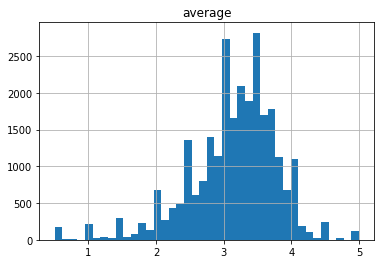

In [127]:
# Find median (and mean) of all ratings

avg_ratings_median = average_ratings['average'].median()
avg_ratings_mean = average_ratings['average'].mean()

print('Median of Average Ratings\n', avg_ratings_median, '\nMean of Average Ratings\n', avg_ratings_mean)
average_ratings.hist(bins=40, column=['average'])

## Sorting by Average Rating

In [129]:
average_ratings = average_ratings.sort_values(by=['average'], ascending=False)

average_ratings.head()
average_ratings.tail()

,movieId,average
17018985,105529,5.0
15254757,117418,5.0
17019042,114193,5.0
17019024,110419,5.0
17019026,111546,5.0


,movieId,average
3399478,109104,0.5
2474450,91573,0.5
10723259,112416,0.5
4436670,124825,0.5
14398624,73196,0.5


## Apply 'Best', 'Worst', 'OK' to 'popularity' as quintiles using qcut

In [130]:
average_ratings['popularity'] = pd.qcut(average_ratings['average'], 5, labels=['Worst', 'lower', 'OK', 'upper', 'Best'])

average_ratings.shape
average_ratings.head()
average_ratings.tail()

(26744, 3)

,movieId,average,popularity
17018985,105529,5.0,Best
15254757,117418,5.0,Best
17019042,114193,5.0,Best
17019024,110419,5.0,Best
17019026,111546,5.0,Best


,movieId,average,popularity
3399478,109104,0.5,Worst
2474450,91573,0.5,Worst
10723259,112416,0.5,Worst
4436670,124825,0.5,Worst
14398624,73196,0.5,Worst


### Divide into popularity buckets, "Best", "Worst", "OK"

In [131]:
# Drop 'upper' and 'lower' popularity scores. Keep only 'Best', 'Worst' and 'OK'

popularity_trio = average_ratings.loc[average_ratings['popularity'].isin(['Best', 'Worst', 'OK'])]

print('Before', average_ratings.shape)
print('After', popularity_trio.shape)
popularity_trio.head()
popularity_trio.tail()

Before (26744, 3)
After (16202, 3)


,movieId,average,popularity
17018985,105529,5.0,Best
15254757,117418,5.0,Best
17019042,114193,5.0,Best
17019024,110419,5.0,Best
17019026,111546,5.0,Best


,movieId,average,popularity
3399478,109104,0.5,Worst
2474450,91573,0.5,Worst
10723259,112416,0.5,Worst
4436670,124825,0.5,Worst
14398624,73196,0.5,Worst


In [132]:
# The classify_age function extracts a year in parens from 'title(year)' and returns a string (e.g. 'old') 

def classify_age(row):
    year = extract_year(row)
    return assign_age(year)

def extract_year(row):
    year_in_parens = re.compile('(?<=\()(\d{4})(?=\))')
    result = year_in_parens.search(row['title'])
    if result:
        return result.group(0)
    else: 
        return None

def assign_age(year):
    if year == None:
        return 'Unknown'
    year = dt.datetime(int(year), 1, 1)
    if year < dt.datetime(1970, 1, 1):
        return 'old'
    elif year < dt.datetime(1990, 1, 1):
        return 'medium'
    else:
        return 'new'

In [133]:
# Applying classify_age returns a new column 'age' with 4 classes: 'old', 'medium', 'new', 'unknown'
# Using categorical data for ease of sorting/visualizing

age_categories = ['new', 'medium', 'old']
ages = movies.apply(classify_age, axis=1)

movies['age'] = pd.Categorical(ages, categories=age_categories, ordered=True)

movies.head(5)

,movieId,title,age
0,1,Toy Story (1995),new
1,2,Jumanji (1995),new
2,3,Grumpier Old Men (1995),new
3,4,Waiting to Exhale (1995),new
4,5,Father of the Bride Part II (1995),new


# Ages Overview

In [15]:
# Calculate number and percentage of each age

age_counts = movies.groupby('age')['movieId'].count()
percentages = age_counts.groupby(level=0).apply(lambda x: 100 * x / 26744)

print('Totals Counts of Each Age\n', age_counts)
print('\nPercentages of Each Age\n', percentages)

Totals Counts of Each Age
 age
new       17118
medium     4674
old        5464
Name: movieId, dtype: int64

Percentages of Each Age
 age
new       64.006880
medium    17.476817
old       20.430751
Name: movieId, dtype: float64


# Merging Data Before Analysis

In [134]:
# Prepare to merge data by dropping title from movie_genres

genres = movie_genres.drop(['title'], axis=1)

# Inner join movies, ratings and genres on 'movieId'

movie_ratings = pd.merge(movies, popularity_trio, on='movieId')
movie_genre_ratings = pd.merge(movie_ratings, genres, on='movieId')

movie_genre_ratings.head()
movie_genre_ratings.tail()

,movieId,title,age,average,popularity,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),new,3.921240,Best,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),new,3.211977,OK,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),new,3.151040,OK,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,5,Father of the Bride Part II (1995),new,3.064592,OK,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,Heat (1995),new,3.834930,Best,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,movieId,title,age,average,popularity,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
16197,131252,Forklift Driver Klaus: The First Day on the Jo...,new,4.0,Best,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
16198,131254,Kein Bund für's Leben (2007),new,4.0,Best,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16199,131256,"Feuer, Eis & Dosenbier (2002)",new,4.0,Best,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16200,131258,The Pirates (2014),new,2.5,Worst,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16201,131262,Innocence (2014),new,4.0,Best,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [137]:
# Re-order columns for ease of use
# movie_genre_ratings = movie_genre_ratings[['movieId', 'average', 'age', 'popularity', 'title']]

movie_genre_ratings.head()
movie_genre_ratings.shape

,movieId,title,age,average,popularity,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),new,3.921240,Best,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),new,3.211977,OK,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),new,3.151040,OK,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,5,Father of the Bride Part II (1995),new,3.064592,OK,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,Heat (1995),new,3.834930,Best,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


(16202, 25)

## Pre-processing Data 

In [156]:
# Fast and loose clean-up. Come back and tidy this up later.

movie_genre_ratings.shape
test_data = movie_genre_ratings.dropna()
test_data.shape

(32178, 6)

(31849, 6)

In [157]:
# Converting categorical data to be consumed by Scikit-Learn

age_map = [
    {'col': 'age', 
    'mapping': 
        [('new', 1), 
        ('medium', 2), 
        ('old', 3)]
    }]
pop_map = [
    {'col': 'popularity', 
    'mapping': 
        [('Best', 1), 
        ('OK', 2), 
        ('Worst', 3)]
    }]

# Encode 'age' ordinally
ce_ord = ce.OrdinalEncoder(cols = ['age'], mapping=cat_map, handle_unknown='ignore')
test_data = ce_ord.fit_transform(test_data)

# Encode 'genres' using OneHot encoding
ce_one_hot = ce.OneHotEncoder(cols =['genres'], use_cat_names=True, handle_unknown='ignore')
test_data = ce_one_hot.fit_transform(test_data)

# Encode 'popularity' ordinally
ce_ord = ce.OrdinalEncoder(cols = ['popularity'], mapping=pop_map, handle_unknown='ignore')
test_data = ce_ord.fit_transform(test_data)

# Split into test and prediction groups.

y = test_data.iloc[:,-2:-1]
X_genres = test_data.iloc[:,:18]
X_age = test_data.iloc[:,-2]
X = test_data.iloc[:,0:-2]

X.head()
y.head()
X.shape

,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Fantasy,genres_Romance,genres_Action,genres_Crime,genres_Thriller,genres_Drama,...,genres_Mystery,genres_Sci-Fi,genres_War,genres_Documentary,genres_Musical,genres_Western,genres_(no genres listed),movieId,average,age
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.92124,1


,popularity
0,1
1,1
2,1
3,1
4,1


(31849, 21)

In [167]:
# Plot 'age' against 'popularity'

model = LinearRegression()

X_array = X_age.values
y_array = y.values

predicted = cross_val_predict(model, X, y, cv=10)

Text(0.5, 0, 'Measured')

Text(0, 0.5, 'Predicted')

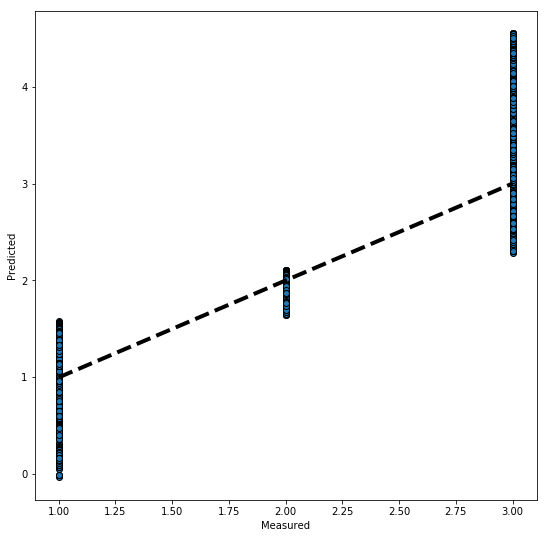

In [163]:






fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()



# sns.set(style="whitegrid")

# # Pull out a specific subset of networks
# genre_names = list(X)[:-3] # list of all genres One Hot Encoded
# used_networks = genre_names
# used_columns = (df.columns.get_level_values("network")
#                           .astype(int)
#                           .isin(used_networks))

# test_data = test_data.iloc[:,0:17]

# # Compute the correlation matrix and average over networks
# corr_df = df.corr().groupby(level="network").mean()
# corr_df.index = corr_df.index.astype(int)
# corr_df = corr_df.sort_index().T

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 6))

# # Draw a violinplot with a narrower bandwidth than the default
# sns.violinplot(data=, palette="Set3", bw=.2, cut=1, linewidth=1)

# # Finalize the figure
# ax.set(ylim=(-.7, 1.05))
# sns.despine(left=True, bottom=True)

In [59]:
# Setting up basic classification prediction
# Extract 55 percent of our dataset randomly, from which to predict outcomes of remaining 45 percent

np.random.shuffle(data_array)





# "Teach" our machine (SVC) about the relationships between 'average' and 'age'
# (but first we need to reshape our X np_array into a 1-D array)

# svc = SVC()

# v = DictVectorizer()

# X_learning = v.fit_transform(X_learning)
# Y_learning = v.fit_transform(Y_learning)

# svc.fit(X_learning, Y_learning)

# # Use the remaining 45 percent of our data as test data
# X = data_array[-14480:][:,0:5]
# Y = data_array[-14480:][:,5]

# predictions = svc.predict(X)

# print("Predicted Results:", predictions)
# print("\nActual Results:", Y)
# print("\nAccuracy rating:  %f" % (accuracy_score(Y, predictions)))

In [ ]:
# print(confusion_matrix(Y, predictions))
print(classification_report(Y, predictions))